# Wheelchair Control

![](images/wheelchair.jpg)

### Python Dependencies

In [2]:
from numpy import *
from numpy.linalg import *

from scipy.linalg import *
from scipy.integrate import *
from scipy.signal import *

from matplotlib.pyplot import *

Step 1 - Wheelchair Planar Model
================================

### Introduction

We consider a simple model of a wheelchair evolving in the plane. It is mainly made of

  - A frame ; from above, its most visible component is the seat. We assume that it is a square,

  - Two fixed wheels (their orientation with respect to the frame does not change). 
    They are parallel and located at opposite ends of the seat. 
    
We assume that the seat backrest is on top of the wheels common axis.


Let $(0, e_x, e_y)$ be a direct orthonormal frame of the plane. We denote 

  - $(x, y)$ the coordinates of the wheel axis center in the orthonormal and 
  - $\theta$ the angle of the wheels direction with respect to vector $e_x$ ; with $\theta = 0$ when the front of the wheelchait faces the right ($e_x$) and $\theta = \pi/2$ when it faces upwards ($e_y$).

  - $\phi_l$ and $\phi_r$ the rotation angles of the left and right wheel respectively ; by convention, when these angles increase, the wheelchair moves forward.

### Parameter Definition

From now on, we assume that the seat side length is $L = 50 \mbox{ cm}$ and the wheel radius is $R_w = 30 \mbox{ cm}$.

🧩 Define the corresponding Python variables `L` and `Rw` (express every length in meters, and more generally in the sequel, always use the [international standard of units](https://en.wikipedia.org/wiki/SI_derived_unit)) for numerical values. 

In [3]:
L = 0.5  # Seat side length in meters (50 cm)
Rw = 0.3  # Wheel radius in meters (30 cm)

### Graphical Representation

🧩 Implement a function `draw_wheelchair` with arguments `x`, `y` and `theta` that draws a simple geometric model of the wheelchair (with seat and fixed wheels) in the plane (top view) for arbitrary values of $(x, y)$ and $\theta$. 

🗝️ **Hint.** Use the function `plot` of `matplotlib.pyplot`.

In [82]:
import matplotlib.pyplot as plt
import numpy as np

L = 0.5  # Seat side length in meters (50 cm)
R_w = 0.3  # Wheel radius in meters (30 cm)

def draw_wheelchair(x, y, theta):
    # Calculate wheel positions
    dx = 0.5 * L * np.sin(theta)
    dy = 0.5 * L * np.cos(theta)
    
    # Draw seat
    seat_corners = [
        (x + L/np.sqrt(2) * np.cos(theta + np.pi/4), y + L/np.sqrt(2) * np.sin(theta + np.pi/4)),
        (x + L/np.sqrt(2) * np.cos(theta + 3*np.pi/4), y + L/np.sqrt(2)* np.sin(theta + 3*np.pi/4)),
        (x + L/np.sqrt(2) * np.cos(theta - 3*np.pi/4), y + L/np.sqrt(2) * np.sin(theta - 3*np.pi/4)),
        (x + L/np.sqrt(2) * np.cos(theta - np.pi/4), y + L/np.sqrt(2) * np.sin(theta - np.pi/4)),
    ]
    seat_corners.append(seat_corners[0])  # Close the loop
    seat_x, seat_y = zip(*seat_corners)
    plt.plot(seat_x, seat_y, 'r')

    # Calculate wheel positions based on the seat corners
    left_wheel_pos = seat_corners[1]
    right_wheel_pos = seat_corners[2]

    # Draw wheels as lines attached to the chair
    wheel_length = L
    left_wheel_start = left_wheel_pos[0] + 0.5 * L * np.cos(theta), left_wheel_pos[1] + 0.5 * L * np.sin(theta)
    left_wheel_end = left_wheel_pos[0] + 1.5 * L * np.cos(theta), left_wheel_pos[1] + 1.5 * L * np.sin(theta)
    right_wheel_start = right_wheel_pos[0] + 0.5 * L * np.cos(theta), right_wheel_pos[1] + 0.5 * L * np.sin(theta)
    right_wheel_end = right_wheel_pos[0] + 1.5 * L * np.cos(theta), right_wheel_pos[1] + 1.5 * L * np.sin(theta)


    plt.plot([left_wheel_start[0], left_wheel_end[0]], [left_wheel_start[1], left_wheel_end[1]], 'b')
    plt.plot([right_wheel_start[0], right_wheel_end[0]], [right_wheel_start[1], right_wheel_end[1]], 'b')
    
    # Set axis limits and aspect ratio
    plt.gca().set_aspect('equal', adjustable='box')


🧩 Represent the wheelchair when $(x, y, \theta) = (0, 0, 0), (2, 2, \pi/2), (0, 4, \pi), (-2, 2, 3\pi/2)$.

🗝️ **Hint.** Use the following `draw_arena` function beforehand.

In [84]:
def draw_arena(xmin, xmax, ymin, ymax):
    wh_ratio = (xmax - xmin) / (ymax - ymin)
    figsize = fig_width, fig_height = 16, 16 / wh_ratio
    figure(figsize=figsize)
    axes = gca()
    axes.axis([xmin, xmax, ymin, ymax])
    axes.set_aspect(1)
    xticks(arange(xmin, xmax+1, 1))
    yticks(arange(ymin, ymax+1, 1))
    grid(True)

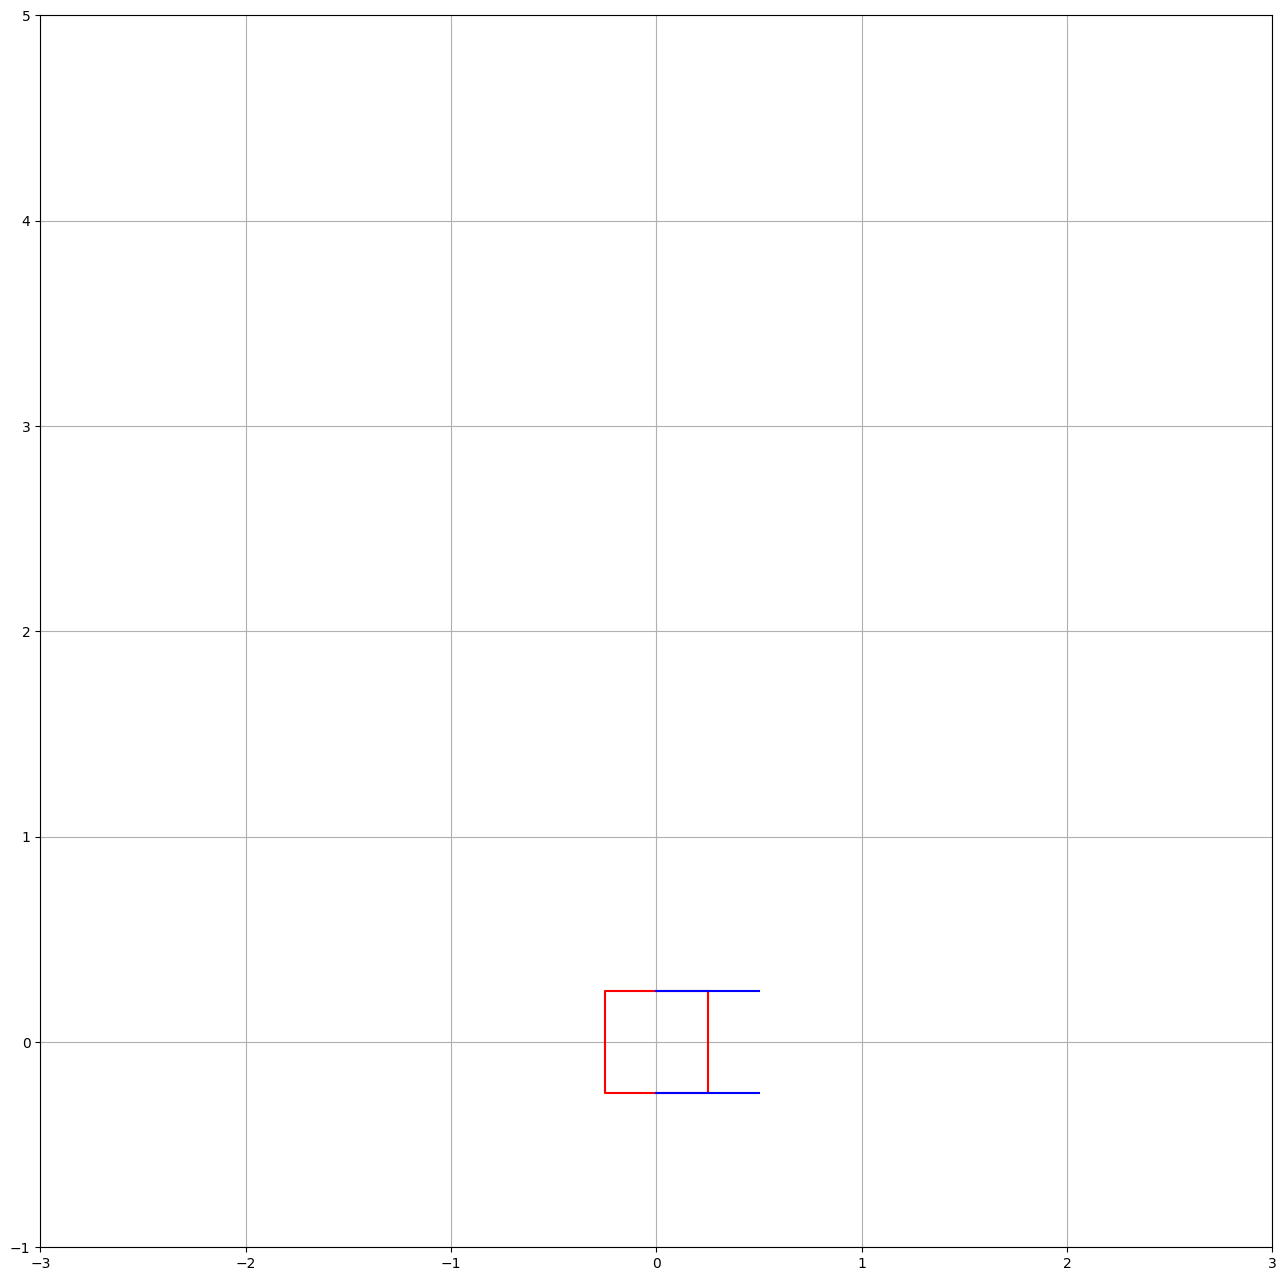

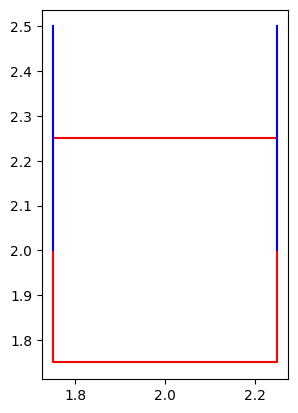

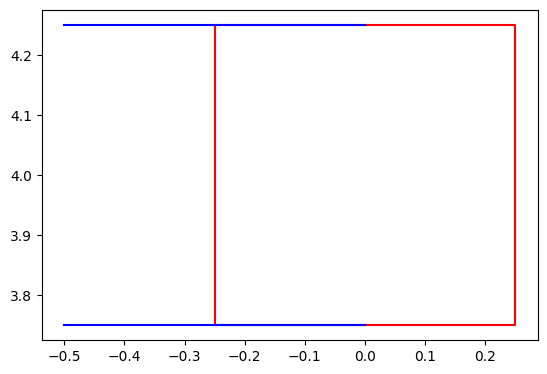

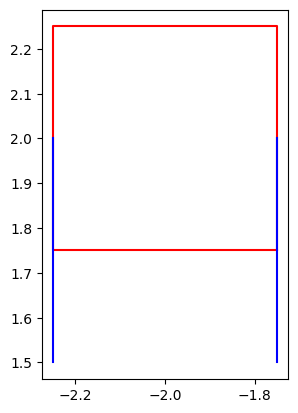

In [86]:
# Set up the arena
draw_arena(-3, 3, -1, 5)

# Draw wheelchairs for the given values of (x, y, theta)
draw_wheelchair(0, 0, 0)
plt.show()
draw_wheelchair(2, 2, np.pi/2)
plt.show()
draw_wheelchair(0, 4, np.pi)
plt.show()
draw_wheelchair(-2, 2, 3*np.pi/2)

# Show the final plot
plt.show()


### Kinematic Modeling

We assume that we can control the wheels angular velocities $\omega_l = \dot{\phi}_l$ and $\omega_r = \dot{\phi}_r$ (this is a *kinematic* model of the wheelchair).
We also assume that the wheelchair fixed wheels roll without slipping. 

🧩 Establish the differential equations that relate $\dot{x}$,
$\dot{y}$ and $\dot{\theta}$ with $\omega_l$ and $\omega_r$.

Let $G_1$ be the center of the right wheel, and $G_2$ the center of the second wheel. We have:
\begin{align*}
\vec{v}{glissement} &= \vec{v}{G_{1}}+\vec{IG_{1}}\times\Vec{w_{r}}=\vec{0}\
\vec{v}{glissement} &= \vec{v}{G_{2}}+\vec{IG_{2}}\times\Vec{w_{l}}=\vec{0}
\end{align*}
We then find that:
\begin{align*}
\vec{v}{G{1}} &= -R_{w}w_{r}(\sin(\theta)\vec{e_{y}}+\cos(\theta)\vec{e_{x}})\
\vec{v}{G{2}} &= -R_{w}w_{l}(\sin(\theta)\vec{e_{y}}+\cos(\theta)\vec{e_{x}})
\end{align*}
If we let the system to be the two wheels concentrated in their center of masses then the center of mass of this system which is the wheel's axis center had a velocity of:
\begin{align*}
\vec{v} &= \frac{R_{w}}{2}(w_{r}\cos(\theta)+w_{l}\cos(\theta))\vec{e_{x}}+\frac{R_{w}}{2}(w_{r}\sin(\theta)+w_{l}\sin(\theta))\vec{e_{x}}\
\dot{x} &= \frac{R_{w}}{2}(w_{l}+w_{r})\cos(\theta)\
\dot{y} &= \frac{R_{w}}{2}(w_{l}+w_{r})\sin(\theta)
\end{align*}
For $\dot{\theta}$ we have $\vec{G_{2}G_{1}}=L\vec{e_{\theta}}$ with $\vec{e_{\theta}}=\cos(\theta)\vec{e_{y}}-\sin(\theta)\vec{e_{x}}$, thus:
\begin{align*}
L\dot{\vec{e_{\theta}}} &= -L\dot{\theta}(\cos{\theta}\vec{e_{x}}+\sin{\theta}\vec{e_{y}})\
\dot{\vec{{G_{2}G_{1}}}} &= \vec{v}{G{1}}-\vec{v}{G{2}}=-R\sin{\theta}(w_{r}-w_{l})\vec{e_{y}}-R\cos{\theta}(w_{r}-w_{l})\vec{e_{x}}
\end{align*}

### Analysis

🧩 Show that if $\omega_l$ and $\omega_r$ are continuously differentiable functions of $(x, y, \theta)$ (which includes the case of constant inputs), this system is well-posed.

**Answer:** Given the differential equations:

$\dot{x} = \frac{R_w(\omega_l + \omega_r)}{2}\cos{\theta}$ ; 
$\dot{y} = \frac{R_w(\omega_l + \omega_r)}{2}\sin{\theta}$ ; 
$\dot{\theta} = \frac{R_w(\omega_r - \omega_l)}{L}$ ; 
with continuously differentiable control inputs $\omega_l$ and $\omega_r$.

$\omega_l + \omega_r$ and $\omega_r - \omega_l$ are continuously differentiable.
$\cos{\theta}$ and $\sin{\theta}$ are smooth functions.
The right-hand sides of the differential equations are continuously differentiable.
Therefore, the system is well-posed.

🧩 Show that if $\omega_l$ and $\omega_r$ are constants, the maximal solution associated to any initial state is global. Is is still true of $\omega_l$ and $\omega_r$ are arbitrary continuously differentiable functions of $(x, y, \theta)$ ?

**Answer** For constant $\omega_l$ and $\omega_r$:

Right-hand sides of the ODEs are smooth functions of $(x, y, \theta)$.

The solutions are continuous.
In this case, the right-hand side of the system is globally Lipschitz continuous with respect to its state variables, since the functions involved are smooth and bounded on a compact set. Therefore, for any initial condition, there exists a unique maximal solution defined on the entire real line, which implies that the maximal solution associated to any initial state is global.
Thus, the maximal solution is global.

For continuously differentiable $\omega_l$ and $\omega_r$:

Global existence of the maximal solution cannot be guaranteed without further information about these functions.
However, if 𝜔𝑙 and 𝜔𝑟 are arbitrary continuously differentiable functions of (𝑥,𝑦,𝜃), then the system of differential equations is no longer autonomous. In this case, the Picard-Lindelöf theorem does not apply, and the existence and uniqueness of solutions may depend on the specific form of the functions 𝜔𝑙 and 𝜔𝑟. Therefore, it is not necessarily true that the maximal solution associated to any initial state is global in this case.

### Vector Field

In the sequel, `omega` is a function that computes the input vector $\omega := (\omega_l, \omega_r)$ given the time $t$ and $(x, y, \theta)$ (thus, it may depend on the time and/or on the system state if needed). For example:

In [87]:
def omega(t, xytheta):
    omega_l = (1 - L/4) * pi / Rw
    omega_r = (1 + L/4) * pi / Rw
    return array([omega_l, omega_r])

🧩 Implement a function `fun(t, xytheta)` that computes $(\dot{x}, \dot{y}, \dot{\theta})$ given the time $t$ and $(x,y,\theta)$ (and implicitly the inputs $\omega$ computed by the function `omega`).

In [88]:
def fun(t, xytheta):
    x, y, theta = xytheta
    omega_l, omega_r = omega(t, xytheta)
    
    dxdt = (Rw * (omega_l + omega_r) / 2) * np.cos(theta)
    dydt = (Rw * (omega_l + omega_r) / 2) * np.sin(theta)
    dthetadt = (Rw * (omega_r - omega_l) / L)
    
    return np.array([dxdt, dydt, dthetadt])


### Simulation Setup

🧩 Simulate the wheelchair dynamics for 4 seconds when $(x_0, y_0, \theta_0)(t=0) = (0.0, 0.0, 0.0)$,
and the wheels velocities are the constants $\omega_l = (1 - L/4)  \pi / R \mbox{ rad/s}$ and $\omega_r = (1 + L/4)  \pi / R_w \mbox{ rad/s}$.
(Compute the dense outputs.)
   

C:\Users\LEOPARD\AppData\Local\Temp\ipykernel_22452\3448757487.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([dxdt, dydt, dthetadt])


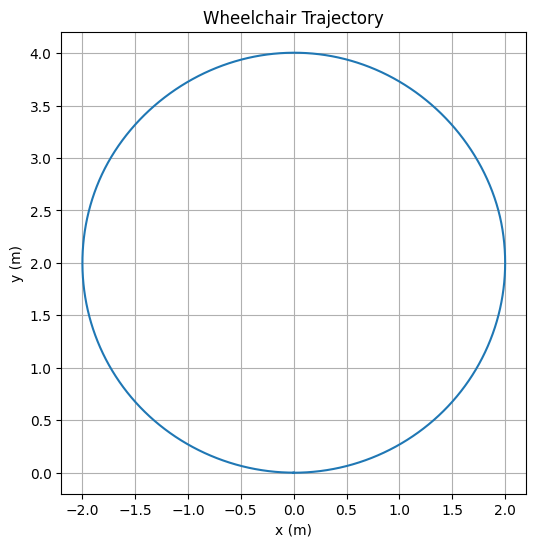

In [89]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Parameters
L = 0.5  # seat side length in meters
Rw = 0.3  # wheel radius in meters

# Function to compute the input vector omega
def omega(t, xytheta):
    omega_l = (1 - L/4) * np.pi / Rw
    omega_r = (1 + L/4) * np.pi / Rw
    return np.array([omega_l, omega_r])

# Initial state
xytheta0 = np.array([0.0, 0.0, 0.0])

# Simulation time span
t_span = (0, 4)

# Time points for dense output
t_eval = np.linspace(0, 4, 1000)

# Solve the system of ODEs
solution = solve_ivp(fun, t_span, xytheta0, t_eval=t_eval, vectorized=True, dense_output=True)

# Plot the trajectory of the wheelchair
x = solution.sol(t_eval)[0]
y = solution.sol(t_eval)[1]

plt.figure(figsize=(6, 6))
plt.plot(x, y)
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title('Wheelchair Trajectory')
plt.grid()
plt.show()


🧩 Use the simulation results to draw the graphs of $x(t)$, $y(t)$ and $\theta(t)$.

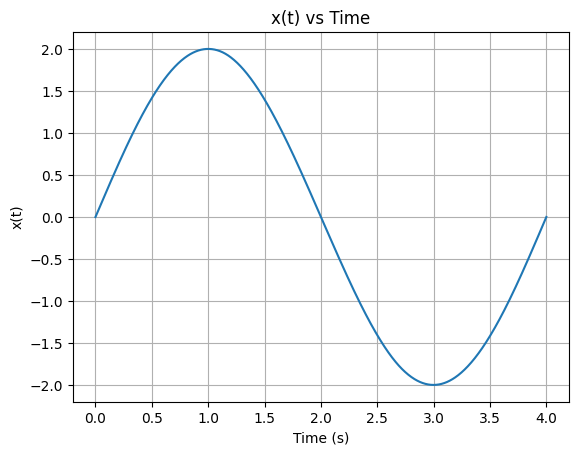

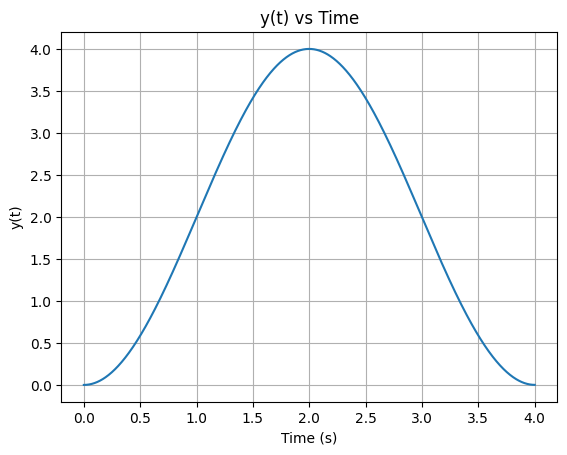

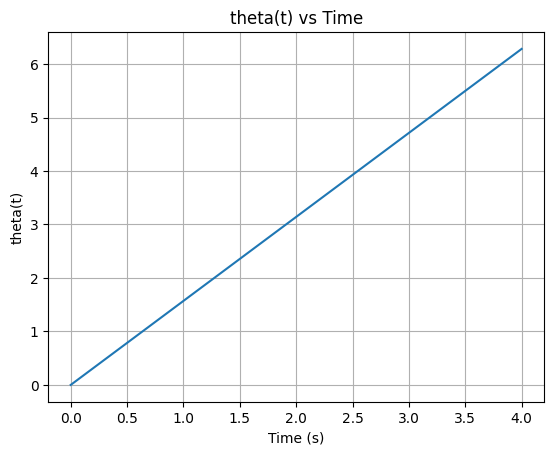

In [91]:
import matplotlib.pyplot as plt

# Extract the time points and state variables from the solution object
t = solution.t
x, y, theta = solution.y

# Plot x(t)
plt.figure()
plt.plot(t, x)
plt.xlabel('Time (s)')
plt.ylabel('x(t)')
plt.title('x(t) vs Time')
plt.grid()

# Plot y(t)
plt.figure()
plt.plot(t, y)
plt.xlabel('Time (s)')
plt.ylabel('y(t)')
plt.title('y(t) vs Time')
plt.grid()

# Plot theta(t)
plt.figure()
plt.plot(t, theta)
plt.xlabel('Time (s)')
plt.ylabel('theta(t)')
plt.title('theta(t) vs Time')
plt.grid()

# Show the plots
plt.show()


🧩 Use the simulation results to display the robot location every 0.5 second.

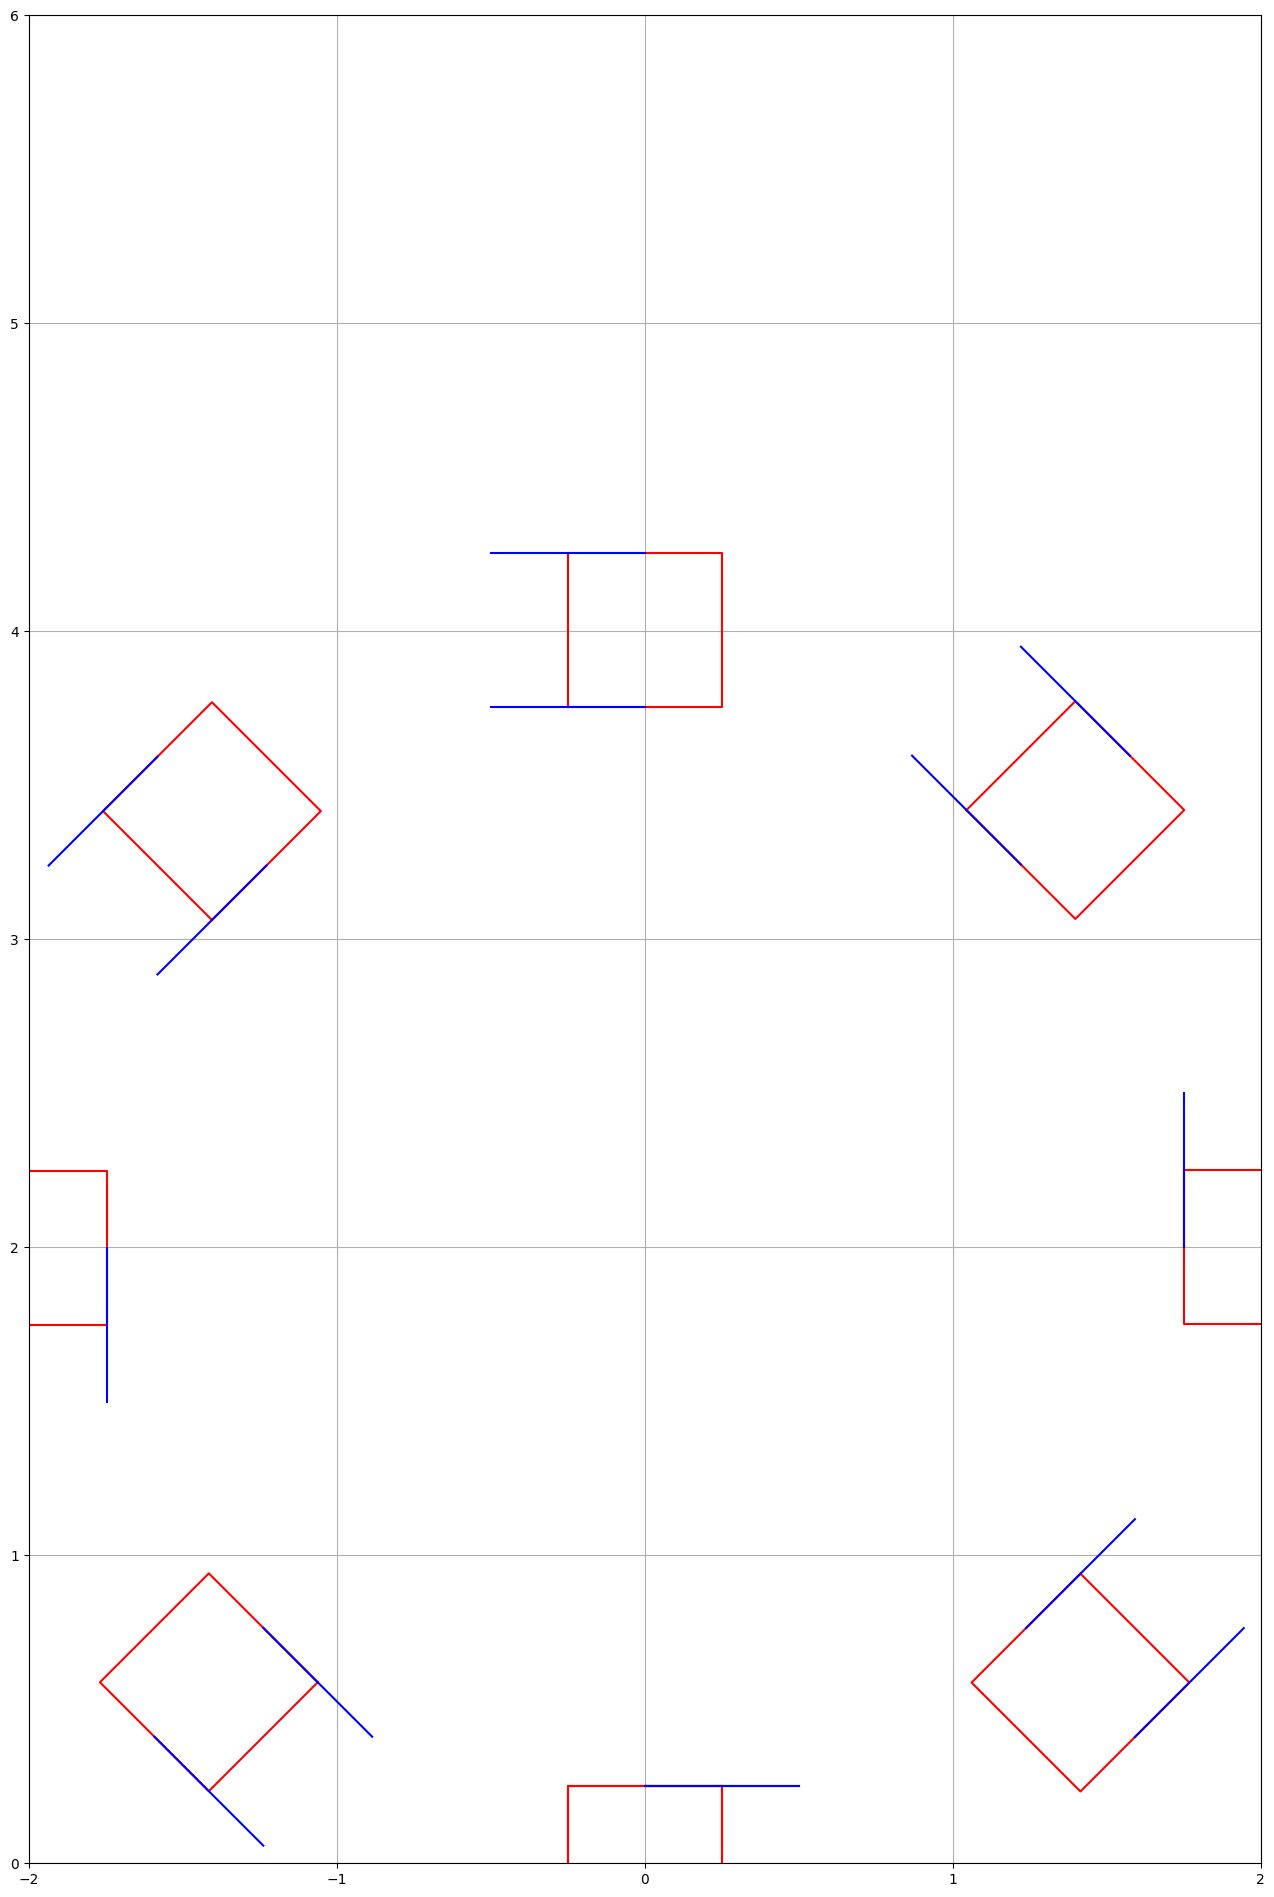

In [92]:
# Time points every 0.5 second
time_points = np.arange(0, 4.5, 0.5)

# Extract the state variables at the specified time points
xytheta_points = [solution.sol(t) for t in time_points]

# Draw the arena
draw_arena(-2, 2, 0, 6)

# Plot the wheelchair's position at each time point
for xytheta in xytheta_points:
    x, y, theta = xytheta
    draw_wheelchair(x, y, theta)

# Show the plot
plt.show()


🧩 What should be the analytical expression of $x(t)$, $y(t)$ and $\theta(t)$? 

**Answer:** Given constant $\omega_l$ and $\omega_r$, the system of ODEs is:

$\dot{x} = \frac{R_w(\omega_l + \omega_r)}{2}\cos{\theta}$ ; 
$\dot{y} = \frac{R_w(\omega_l + \omega_r)}{2}\sin{\theta}$ ; 
$\dot{\theta} = \frac{R_w(\omega_r - \omega_l)}{L}$ 
Analytical expressions for $x(t)$, $y(t)$, and $\theta(t)$:

$\theta(t) = \frac{R_w(\omega_r - \omega_l)}{L}t + \theta_0$
$x(t) = \frac{R_w(\omega_l + \omega_r)}{2L}(\sin(\theta(t)) - \sin(\theta_0)) + x_0$
$y(t) = \frac{R_w(\omega_l + \omega_r)}{2L}(-\cos(\theta(t)) + \cos(\theta_0)) + y_0$




🧩 Do you experimental results match the theoretical results ? Draw the curves of the simulation error at time $t$ for $x$, $y$ and $\theta$.

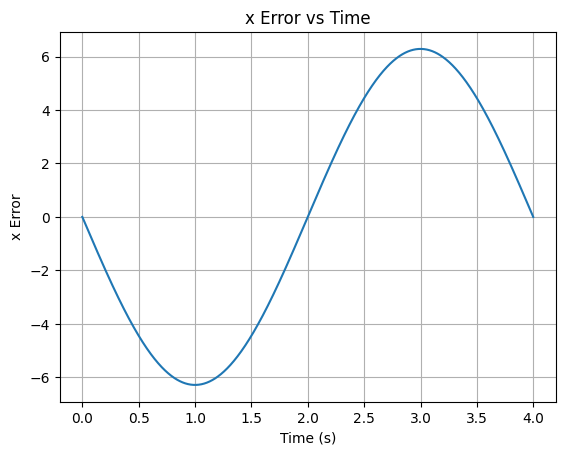

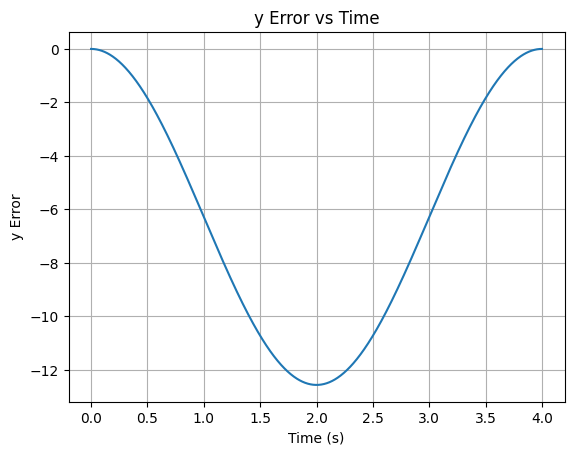

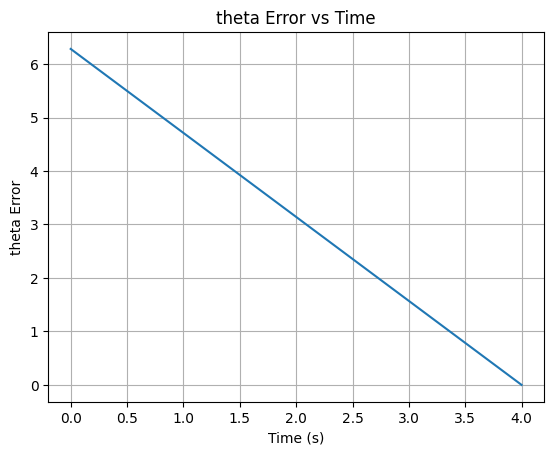

In [93]:
omega_l = (1 - L/4) * np.pi / Rw
omega_r = (1 + L/4) * np.pi / Rw

def theoretical_xytheta(t, x0, y0, theta0):
    theta_t = (Rw * (omega_r - omega_l) / L) * t + theta0
    x_t = (Rw * (omega_l + omega_r) / (2 * L)) * (np.sin(theta_t) - np.sin(theta0)) + x0
    y_t = (Rw * (omega_l + omega_r) / (2 * L)) * (-np.cos(theta_t) + np.cos(theta0)) + y0
    return x_t, y_t, theta_t

# Calculate the theoretical values
x_theoretical, y_theoretical, theta_theoretical = theoretical_xytheta(t, 0, 0, 0)

# Calculate the errors
x_error = x - x_theoretical
y_error = y - y_theoretical
theta_error = theta - theta_theoretical

# Plot the error curves
plt.figure()
plt.plot(t, x_error)
plt.xlabel('Time (s)')
plt.ylabel('x Error')
plt.title('x Error vs Time')
plt.grid()

plt.figure()
plt.plot(t, y_error)
plt.xlabel('Time (s)')
plt.ylabel('y Error')
plt.title('y Error vs Time')
plt.grid()

plt.figure()
plt.plot(t, theta_error)
plt.xlabel('Time (s)')
plt.ylabel('theta Error')
plt.title('theta Error vs Time')
plt.grid()

plt.show()


🧩 If needed, adjust the simulation parameters until this error is uniformly less than $2 \times 10^{-5}$ for every component of $(x, y, \theta)$.

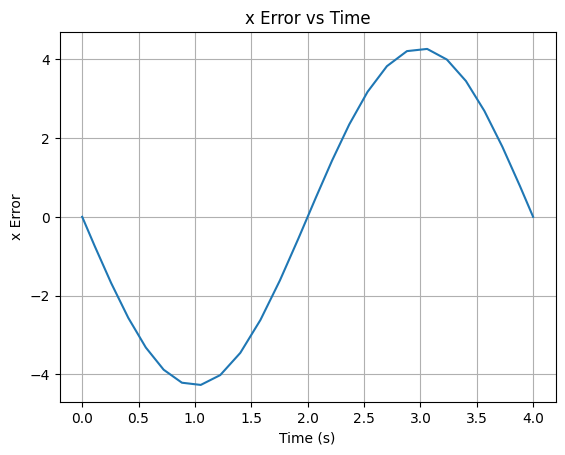

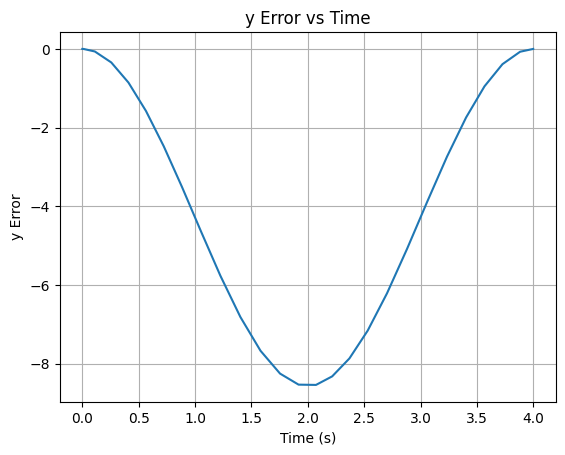

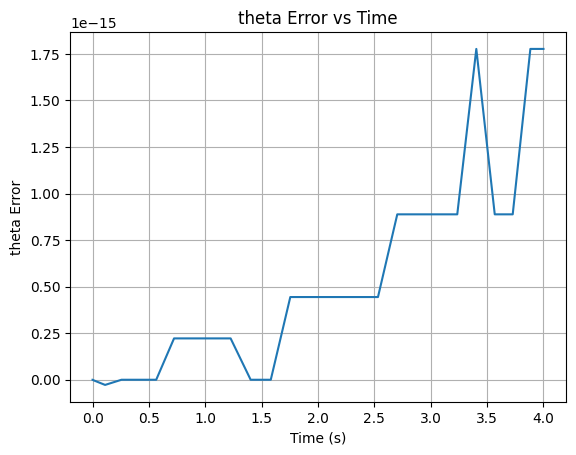

In [94]:
from scipy.integrate import solve_ivp

# Set up the initial conditions and time span for the simulation
initial_conditions = [0.0, 0.0, 0.0]
t_span = [0, 4]

# Run the simulation with adjusted tolerances
solution = solve_ivp(fun, t_span, initial_conditions, dense_output=True, rtol=1e-8, atol=1e-8)

# Extract the time points and state variables from the simulation results
t = solution.t
x, y, theta = solution.y

# Calculate the theoretical values
x_theoretical, y_theoretical, theta_theoretical = theoretical_xytheta(t, 0, 0, 0)

# Calculate the errors
x_error = x - x_theoretical
y_error = y - y_theoretical
theta_error = theta - theta_theoretical

# Plot the error curves
plt.figure()
plt.plot(t, x_error)
plt.xlabel('Time (s)')
plt.ylabel('x Error')
plt.title('x Error vs Time')
plt.grid()

plt.figure()
plt.plot(t, y_error)
plt.xlabel('Time (s)')
plt.ylabel('y Error')
plt.title('y Error vs Time')
plt.grid()

plt.figure()
plt.plot(t, theta_error)
plt.xlabel('Time (s)')
plt.ylabel('theta Error')
plt.title('theta Error vs Time')
plt.grid()

plt.show()

